# Do NNs actually need the parameters?
### Spoiler: Not really :D



I take the idea from lectures regarding CNNs: in natural signals, most of the parameters of a Fully Connected Model do not contribute much to the result.

I take this one step further, to see if these models 'waste' parameters on other datasets as well. If so, can we boil the model down into a smaller subset of parameters that may be computationally more efficient.

# Hypothesis
A fully connected Neural network is dense, i.e each 'neuron' is connected to _all_ other neurons in a layer. However, in most cases, a given feature in a dataset is not well related to _every_ other feature.  
Due to this, I hypothesize that in arbitrary datasets, a significant proportion of the parameters in an NN are useless, i.e removing them does not effect the performance of the model.  

# Experimental Design:

For a given dataset and a trained NN, I vary the number of parameters retained, while keeping all other parameters unchanged. I then compare different proportions of retained parameters, and analyze the point at which the performance drops. 
Importantly, I choose the initial architecture of the NN to be the smallest model that achieves reasonable performance. This accounts for the possibility that the NN could be overparameterized to begin with, making the experiment essentially useless. 
This control makes the experiment sufficient to test the hypothesis. 

## Overview

1. On a given dataset, find the smallest model that achieves reasonable performance. 
    - I limit to 1 layer NNs for clarity and consistency. One can easily check that the results hold for multiple layers as well. 
    - Importantly, we pick the model which is much better than a slightly smaller one, i.e at the elbow of the performance vs parameters graph.
2. Train this model completely.
3. Start pruning away weights with smallest magnitude ( $|w_i| \approx 0$ )
4. Check the accuracy of this pruned model

Extra:

5. Store the initial (untrained) weights of the complete model. 
6. Re-train the pruned model using these weights.
6. Check accuracy of this model.  

## Datasets
I test on the following datasets, you can add more in the `DataHandler` class if you want to experiment further! 
1. `Swiss Roll`: Classic toy 3D dataset from sklearn (spatial data)
2. `Diabetes`: Another classic sklearn dataset that aims to classify whether a sample has diabetes based on given features (real-world data)
3. `MNIST`: For benchmarking, since we already know most params are wasted here (visual data)


Go to the [Results](#results) section to skip the boring part :D

# Experiment Code

## Import Libraries

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.datasets import make_swiss_roll, load_diabetes, fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np
import matplotlib.pyplot as plt
import copy

## Dataset Handler

In [2]:
class DatasetHandler:
    def __init__(self, name="swiss_roll", batch_size=64, seed=42):
        self.name = name
        self.batch_size = batch_size
        self.seed = seed
        self.input_dim = None
        self.output_dim = None
        self.train_loader = None
        self.test_loader = None

        self._prepare_data()

    def _prepare_data(self):
        # Reproducibility
        torch.manual_seed(self.seed)
        np.random.seed(self.seed)

        if self.name == "swiss_roll":
            print("Loading Swiss Roll...")
            X, t = make_swiss_roll(n_samples=3000, noise=0.1, random_state=self.seed)
            X = StandardScaler().fit_transform(X)
            # Bin continuous 't' into 4 classes
            y = np.digitize(t, bins=np.linspace(np.min(t), np.max(t), 5)[1:-1])
            self.input_dim = 3
            self.output_dim = 4

        elif self.name == "mnist":
            print("Loading MNIST (this may take a moment)...")
            mnist = fetch_openml('mnist_784', version=1, as_frame=False, parser='auto')

            # Subsample 10k
            indices = np.random.choice(len(mnist.data), 10000, replace=False)
            X = mnist.data[indices].astype('float32') / 255.0
            y = mnist.target[indices].astype('int64')

            self.input_dim = 784
            self.output_dim = 10

        elif self.name == "diabetes":
            print("Loading Diabetes...")
            diabetes = load_diabetes()
            X = StandardScaler().fit_transform(diabetes.data)
            t = diabetes.target

            # Diabetes is regression. To use Accuracy/CrossEntropy, we bin it based on median
            median_val = np.median(t)
            y = (t > median_val).astype(int)

            self.input_dim = X.shape[1] # 10 features
            self.output_dim = 2 # Binary classification

        else:
            raise ValueError(f"Unknown dataset: {self.name}")

        # Convert to Tensors
        X_tensor = torch.FloatTensor(X)
        y_tensor = torch.LongTensor(y)

        # Split
        X_train, X_test, y_train, y_test = train_test_split(
            X_tensor, y_tensor, test_size=0.2, random_state=self.seed
        )

        # Create Loaders
        train_ds = TensorDataset(X_train, y_train)
        test_ds = TensorDataset(X_test, y_test)

        self.train_loader = DataLoader(train_ds, batch_size=self.batch_size, shuffle=True)
        self.test_loader = DataLoader(test_ds, batch_size=self.batch_size, shuffle=False)

        print(f"Dataset '{self.name}' prepared. Input: {self.input_dim}, Output: {self.output_dim}")

## MLP Class (For arbitrary size)

In [ ]:
# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
class FlexibleMLP(nn.Module):
    def __init__(self, input_dim, output_dim, hidden_dims):
        super(FlexibleMLP, self).__init__()
        layers = []
        in_d = input_dim

        for h_d in hidden_dims:
            layers.append(nn.Linear(in_d, h_d))
            layers.append(nn.ReLU())
            in_d = h_d

        layers.append(nn.Linear(in_d, output_dim))
        self.network = nn.Sequential(*layers)

    def forward(self, x):
        return self.network(x)

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Finder for the best architecture
Looks for the elbow* in the plot between # parameters vs accuracy

*For simplicity, take elbow to be the first model that goes below 5% of the max acc

Note: You can uncomment other architectures in `self.configs` to experiment further

In [4]:
class ArchitectureFinder:
    def __init__(self, dataset_handler):
        self.ds = dataset_handler
        self.configs = [
            # 3 layers
            # [512, 256, 128],
            # [256, 128, 64],
            # [128, 64, 32],
            # [64, 32, 16],
            # [32, 16, 8],
            # # 2 layers
            # [128, 64],
            # [64, 32],
            # [64, 32],
            # [32, 16],
            # [16, 8],
            # [8, 4],
            # [4, 2],
            # 1 layers
            [512], 
            [256], 
            [128],
            [64],
            [32],
            [16],
            [8],
            [4]
        ]
        self.configs.sort(key=sum, reverse=True)
        self.num_config_params = []
        self.results = []
        self.chosen = None

    def _train_eval(self, config):
        model = FlexibleMLP(self.ds.input_dim, self.ds.output_dim, config).to(device)
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        criterion = nn.CrossEntropyLoss()

        model.train()
        for epoch in range(20):
            for X_b, y_b in self.ds.train_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)
                optimizer.zero_grad()
                loss = criterion(model(X_b), y_b)
                loss.backward()
                optimizer.step()

        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_b, y_b in self.ds.test_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)
                _, predicted = torch.max(model(X_b), 1)
                total += y_b.size(0)
                correct += (predicted == y_b).sum().item()

        return 100 * correct / total, count_parameters(model)

    def find_best(self):
        print("--- Finding Optimal Architecture ---")
        self.results = []
        for conf in self.configs:
            acc, params = self._train_eval(conf)
            self.results.append({'config': conf, 'params': params, 'accuracy': acc})
            self.num_config_params.append(params)
            print(f"Config: {conf}, Params: {params}, Accuracy: {acc:.2f}%")

        self._plot_results()
        self.chosen = self._select_elbow()
        return self.chosen

    def _select_elbow(self):
        # Heuristic: Smallest model within 5% of max accuracy
        accuracies = [r['accuracy'] for r in self.results]
        best_acc = max(accuracies)
        threshold = best_acc - 5.0

        sorted_res = sorted(self.results, key=lambda x: x['params'])
        for res in sorted_res:
            if res['accuracy'] >= threshold:
                print(f"Selected Optimal Config: {res['config']}")
                return res['config']
        return sorted_res[-1]['config'] # Fallback to largest

    def _plot_results(self):
        params = [r['params'] for r in self.results]
        accs = [r['accuracy'] for r in self.results]
        plt.figure(figsize=(6, 4))
        plt.plot(params, accs, marker='o')
        plt.xscale('log')
        plt.xlabel('Parameters (log)')
        plt.ylabel('Accuracy %')
        plt.title('Architecture Search')
        plt.grid(True)
        plt.show()

## Pruning Experiment Code
Trains and tests a full model, and then removes $p\%$ of weights that have the lowest magnitude (closest to 0).

Removal, here, is simply a mask with 0s where weights are removed.

In [5]:
import copy
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import seaborn as sns

class PruningExperiment:
    def __init__(self, dataset_handler, architecture_config):
        self.ds = dataset_handler
        self.config = architecture_config
        self.initial_state = None  # W_0
        self.base_model_state = None # W_final
        self.criterion = nn.CrossEntropyLoss()

        self.history = {}

    def _train(self, model, optimizer, mask=None, epochs=50):
        model.train()
        for epoch in range(epochs):
            for X_b, y_b in self.ds.train_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)

                optimizer.zero_grad()
                out = model(X_b)
                loss = self.criterion(out, y_b)
                loss.backward()

                # Apply Mask to Gradients (Freeze pruned weights)
                if mask:
                    with torch.no_grad():
                        idx = 0
                        for name, param in model.named_parameters():
                            if 'weight' in name:
                                param.grad *= mask[idx]
                                idx += 1

                optimizer.step()

    def _evaluate(self, model):
        model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for X_b, y_b in self.ds.test_loader:
                X_b, y_b = X_b.to(device), y_b.to(device)
                _, predicted = torch.max(model(X_b), 1)
                total += y_b.size(0)
                correct += (predicted == y_b).sum().item()
        return 100 * correct / total

    def _create_global_mask(self, model, p_percent):
        all_weights = []
        for name, param in model.named_parameters():
            if 'weight' in name:
                all_weights.append(param.data.view(-1))

        all_weights_flat = torch.cat(all_weights)

        if p_percent == 0:
            threshold = -1.0
        else:
            threshold = torch.quantile(all_weights_flat.abs(), p_percent / 100.0)

        masks = []
        for name, param in model.named_parameters():
            if 'weight' in name:
                mask = (param.data.abs() > threshold).float().to(device)
                masks.append(mask)
        return masks

    def _apply_mask_to_model(self, model, masks):
        """Helper to zero out weights in a model based on masks."""
        with torch.no_grad():
            idx = 0
            for name, param in model.named_parameters():
                if 'weight' in name:
                    param.data *= masks[idx]
                    idx += 1

    def visualize_masks(self, p):
        """Retrieves masks for p and visualizes them."""
        if p not in self.history:
            print(f"No history for p={p}")
            return

        masks = self.history[p]['mask']

        temp_model = FlexibleMLP(self.ds.input_dim, self.ds.output_dim, self.config).to(device)
        visualize_active_parameters(temp_model, masks, p)

    def run(self, p_values=[0, 20, 40, 60, 80]):
        # 1. Initialize
        print("\n--- Starting Pruning Experiment ---")
        base_model = FlexibleMLP(self.ds.input_dim, self.ds.output_dim, self.config).to(device)

        # Save W_0 (Initialization)
        self.initial_state = copy.deepcopy(base_model.state_dict())

        # 2. Train Full Base Model
        print("Training dense base model (W_final)...")
        opt = optim.Adam(base_model.parameters(), lr=0.001)
        self._train(base_model, opt, epochs=50)

        # Save W_final (Dense Trained)
        self.base_model_state = copy.deepcopy(base_model.state_dict())
        base_acc = self._evaluate(base_model)
        print(f"Base Dense Accuracy: {base_acc:.2f}%")

        results_retrained = []
        results_original_masked = []

        # 3. Iterative Pruning Loop
        for p in p_values:
            print(f"\nProcessing p={p}%...")

            #  A. Create Mask ---
            base_model.load_state_dict(self.base_model_state)
            masks = self._create_global_mask(base_model, p)

            # --- B. Evaluate "Original + Mask" (Pruning without Retraining) ---
            masked_base_model = FlexibleMLP(self.ds.input_dim, self.ds.output_dim, self.config).to(device)
            masked_base_model.load_state_dict(self.base_model_state)
            self._apply_mask_to_model(masked_base_model, masks)
            acc_orig_masked = self._evaluate(masked_base_model)

            # --- C. Evaluate "Retrained + Mask" (Lottery Ticket) ---
            retrained_model = FlexibleMLP(self.ds.input_dim, self.ds.output_dim, self.config).to(device)
            retrained_model.load_state_dict(self.initial_state)
            self._apply_mask_to_model(retrained_model, masks)

            opt_retrained = optim.Adam(retrained_model.parameters(), lr=0.001)
            self._train(retrained_model, opt_retrained, mask=masks, epochs=50)

            acc_retrained = self._evaluate(retrained_model)

            # --- D. Store Everything ---
            self.history[p] = {
                'mask': masks,
                'model_retrained_state': copy.deepcopy(retrained_model.state_dict()),
                'acc_retrained': acc_retrained,
                'acc_original_masked': acc_orig_masked
            }

            results_retrained.append(acc_retrained)
            results_original_masked.append(acc_orig_masked)

            print(f"  > Retrained (Lottery): {acc_retrained:.2f}%")
            print(f"  > Original Masked (Direct Prune): {acc_orig_masked:.2f}%")

        self._plot_comparison(p_values, results_retrained, results_original_masked)

    def _plot_comparison(self, p_vals, retrained, original_masked):
        plt.figure(figsize=(10, 6))

        plt.plot(p_vals, retrained, marker='o', label='Retrained (Lottery Ticket)', color='purple')

        plt.plot(p_vals, original_masked, marker='x', linestyle='--', label='Original Masked (Naive Pruning)', color='gray')

        plt.xlabel('Percent of Parameters Pruned')
        plt.ylabel('Accuracy (%)')
        plt.title('Lottery Ticket Hypothesis: Retraining vs Direct Pruning')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()

def visualize_active_parameters(model, masks, p_percent):
    layer_names = [name for name, _ in model.named_parameters() if 'weight' in name]
    n_layers = len(masks)
    fig, axes = plt.subplots(1, n_layers, figsize=(4 * n_layers, 4))
    if n_layers == 1: axes = [axes]

    total_active = 0
    total_params = 0

    for i, mask in enumerate(masks):
        mask_np = mask.cpu().numpy()
        active = mask_np.sum()
        total = mask_np.size
        total_active += active
        total_params += total

        ax = axes[i]
        sns.heatmap(mask_np, ax=ax, cbar=False, cmap="viridis", vmin=0, vmax=1)
        layer_name = layer_names[i].replace(".weight", "")
        ax.set_title(f"{layer_name}\nActive: {int(active)}/{total}")
        if mask_np.shape[0] > 50 or mask_np.shape[1] > 50:
            ax.set_xticks([]); ax.set_yticks([])

    sparsity = 100 * (1 - total_active / total_params)
    plt.suptitle(f"Active Weights p={p_percent}%", y=1.05)
    plt.xlabel("Layer Input")
    plt.ylabel("Layer Output")
    plt.tight_layout()
    plt.show()

## Visualization and Utils

In [6]:
def visualize_pixel_importance(model, dataset_handler, sample_index=0):
    """
    Visualizes the importance of input pixels for an MNIST model.

    Importance is defined as the normalized average absolute weight connected
    to a specific pixel across all neurons in the first hidden layer.

    Args:
        model: The trained PyTorch model.
        dataset_handler: The handler containing the test_loader (to get a sample).
        sample_index: Which image from the test batch to visualize.
    """
    model.eval()

    # 1. Get a sample image
    data_iter = iter(dataset_handler.test_loader)
    images, labels = next(data_iter)

    # Pick the specific sample
    img_flat = images[sample_index].to(device)  # Shape: [784]
    label = labels[sample_index].item()

    # Reshape for visualization
    side = int(np.sqrt(dataset_handler.input_dim))
    img_2d = img_flat.cpu().view(side, side).numpy()

    # 2. Extract Input Layer Weights
    first_layer_weights = model.network[0].weight.data # Shape: [hidden_dim, input_dim]

    # 3. Compute Importance Map
    avg_abs_weights = torch.mean(torch.abs(first_layer_weights), dim=0) # Shape: [input_dim]

    # Normalize to [0, 1]
    w_min = avg_abs_weights.min()
    w_max = avg_abs_weights.max()
    importance_map = (avg_abs_weights - w_min) / (w_max - w_min)

    # Reshape to 2D
    importance_map_2d = importance_map.cpu().view(side, side).numpy()

    # 4. Visualization
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    # A. Original Image
    sns.heatmap(img_2d, ax=axes[0], cmap="gray", cbar=False, square=True)
    axes[0].set_title(f"Original Digit: {label}")
    axes[0].axis('off')

    # B. Weight Importance Heatmap
    sns.heatmap(importance_map_2d, ax=axes[1], cmap="inferno", square=True)
    axes[1].set_title("Pixel Importance\n(Avg Abs Weight)")
    axes[1].axis('off')

    # C. Overlay (Masking the image with importance)
    overlay = img_2d * importance_map_2d
    sns.heatmap(overlay, ax=axes[2], cmap="magma", square=True)
    axes[2].set_title("Weighted Input\n(Image * Importance)")
    axes[2].axis('off')

    plt.tight_layout()
    plt.show()

In [7]:
# @title Advanced Result Visualization
from sklearn.metrics import confusion_matrix
import seaborn as sns

class ResultExplorer:
    def __init__(self, experiment):
        self.exp = experiment

def plot_layer_sparsity(exp, p):
    """
    Bar chart showing what % of parameters were pruned in EACH layer.
    Global pruning often results in non-uniform layer sparsity.
    """
    if p not in exp.history:
        print(f"No data for p={p}")
        return

    masks = exp.history[p]['mask']
    layer_names = [n.replace('.weight', '') for n, _ in exp.initial_state.items() if 'weight' in n]

    sparsities = []
    for m in masks:
        total = m.numel()
        active = m.sum().item()
        sparsities.append(100 * (1 - active/total))

    plt.figure(figsize=(8, 4))
    sns.barplot(x=layer_names, y=sparsities, palette="magma")
    plt.ylabel("% Pruned")
    plt.title(f"Layer-wise Sparsity at Global p={p}%")
    plt.ylim(0, 100)
    plt.grid(axis='y', alpha=0.3)
    plt.show()

def plot_weight_distribution(exp, p):
    """
    Overlays the weight histograms of the Dense Base Model vs Retrained Sparse Model.
    """
    if p not in exp.history: return

    # Gather weights
    dense_weights = []
    for k, v in exp.base_model_state.items():
        if 'weight' in k: dense_weights.append(v.cpu().numpy().flatten())
    dense_weights = np.concatenate(dense_weights)

    sparse_state = exp.history[p]['model_retrained_state']
    sparse_weights = []
    for k, v in sparse_state.items():
        if 'weight' in k: sparse_weights.append(v.cpu().numpy().flatten())
    sparse_weights = np.concatenate(sparse_weights)

    # Remove exact zeros from sparse weights for the plot (to see the distribution of surviving weights)
    sparse_weights_nonzero = sparse_weights[sparse_weights != 0]

    plt.figure(figsize=(10, 5))
    sns.kdeplot(dense_weights, fill=True, label='Original Dense Model', color='gray', alpha=0.3)
    sns.kdeplot(sparse_weights_nonzero, fill=True, label=f'Retrained Sparse ({p}%)', color='purple', alpha=0.3)
    plt.xlim(-10, 10) # Zoom in near zero
    plt.title(f"Weight Distribution Shift (p={p}%)")
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.show()

In [8]:
# @title Class-Averaged Probability Analysis
import matplotlib.cm as cm

def analyze_class_average_trends(experiment):
    """
    Analyzes probability distributions averaged over ALL samples of the same class.

    Returns visualization of:
    1. Average Confidence (Std Dev) vs Pruning % (Per Class)
    2. Average Probability assigned to the True Class vs Pruning % (Per Class)
    """
    ds = experiment.ds
    p_values = sorted(experiment.history.keys())
    num_classes = ds.output_dim

    # Storage structure: stats[class_id][p] = {'avg_std': ..., 'avg_correct_prob': ...}
    stats = {c: {'stds': [], 'correct_probs': []} for c in range(num_classes)}

    print(f"Analyzing trends across {num_classes} classes...")

    # 1. Pre-group data by class to avoid repeated filtering
    class_indices = {c: [] for c in range(num_classes)}
    all_images = []
    all_labels = []

    with torch.no_grad():
        for X, y in ds.test_loader:
            all_images.append(X)
            all_labels.append(y)

    X_test = torch.cat(all_images).to(device)
    y_test = torch.cat(all_labels).to(device)

    for c in range(num_classes):
        # Find indices where label == c
        class_indices[c] = (y_test == c).nonzero(as_tuple=True)[0]

    # 2. Iterate through pruning levels
    for p in p_values:
        # Load Model for this p
        model = FlexibleMLP(ds.input_dim, ds.output_dim, experiment.config).to(device)
        model.load_state_dict(experiment.history[p]['model_retrained_state'])
        model.eval()

        # Get predictions for the WHOLE test set at once
        with torch.no_grad():
            logits = model(X_test)
            probs = torch.nn.functional.softmax(logits, dim=1) # [N, num_classes]

            # Calculate Std Dev for every sample
            sample_stds = torch.std(probs, dim=1)

            # Extract probability assigned to the CORRECT class
            correct_probs = probs.gather(1, y_test.view(-1, 1)).squeeze()

        # 3. Aggregate per class
        for c in range(num_classes):
            idx = class_indices[c]
            if len(idx) == 0: continue

            # Average Std Dev for this class
            avg_std = sample_stds[idx].mean().item()
            stats[c]['stds'].append(avg_std)

            # Average Probability of the True Class
            avg_correct = correct_probs[idx].mean().item()
            stats[c]['correct_probs'].append(avg_correct)

    # --- PLOTTING ---
    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    colors = cm.get_cmap('tab10', num_classes)

    # Plot A: Average Confidence (Std Dev)
    for c in range(num_classes):
        axes[0].plot(p_values, stats[c]['stds'], marker='.', label=f'Class {c}', color=colors(c))

    axes[0].set_title("Average Prediction Confidence (Std Dev)\n(Higher = More Peaked/Confident)")
    axes[0].set_xlabel("Pruning Percentage (p)")
    axes[0].set_ylabel("Avg Std Dev of Prob Vector")
    axes[0].grid(True, alpha=0.3)

    # Plot B: Robustness (Avg Prob of True Class)
    for c in range(num_classes):
        axes[1].plot(p_values, stats[c]['correct_probs'], marker='.', label=f'Class {c}', color=colors(c))

    axes[1].set_title("Average Probability Assigned to Correct Class\n(Higher = More Robust)")
    axes[1].set_xlabel("Pruning Percentage (p)")
    axes[1].set_ylabel("Avg Probability of True Label")
    axes[1].set_ylim(0, 1.05)
    axes[1].grid(True, alpha=0.3)
    axes[1].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    plt.tight_layout()
    plt.show()


In [9]:
# @title Combined Visualization

def plot_all_results(dataset_names, arch_finders, experiments):
    """
    Generates a summary figure for each dataset containing:
    1. Architecture Search Curve (highlighting the chosen 'Elbow').
    2. Pruning Performance Curve (Lottery Ticket vs Naive).
    """

    for i, ds_name in enumerate(dataset_names):
        print(f"Generating summary for {ds_name}...")

        # Get the specific objects for this dataset
        finder = arch_finders[i]
        exp = experiments[i]

        # Create Figure
        fig, axes = plt.subplots(1, 2, figsize=(16, 6))

        # --- SUBPLOT 1: Architecture Search ---
        ax1 = axes[0]

        # Extract data from finder
        # results is a list of dicts: {'config', 'params', 'accuracy'}
        params = [r['params'] for r in finder.results]
        accs = [r['accuracy'] for r in finder.results]

        # sort params and acc w.r.t params
        params, accs = zip(*sorted(zip(params, accs), key=lambda x: x[0]))

        # Plot all points
        ax1.plot(params, accs, marker='o', linestyle='-', color='steelblue', label='Architectures')

        # Identify and Highlight the Chosen Model
        # We need to match the chosen config to find its specific params/acc
        chosen_config = finder.chosen # This re-runs the selection logic to ensure we have the right one

        chosen_pt = None
        for res in finder.results:
            if res['config'] == chosen_config:
                chosen_pt = res
                break

        if chosen_pt:
            ax1.scatter(chosen_pt['params'], chosen_pt['accuracy'],
                        color='gold', s=200, edgecolor='black', zorder=5, marker='*',
                        label=f'Chosen (Elbow)\n{chosen_pt["params"]:,} params')

            # Annotate
            ax1.annotate(f"{chosen_pt['accuracy']:.1f}%",
                         (chosen_pt['params'], chosen_pt['accuracy']),
                         xytext=(0, 10), textcoords='offset points', ha='center')

        ax1.set_xscale('log')
        ax1.set_xlabel("Number of Parameters (Log Scale)")
        ax1.set_ylabel("Validation Accuracy (%)")
        ax1.set_title(f"1. Architecture Search: {ds_name.upper()}")
        ax1.grid(True, which="both", ls="-", alpha=0.3)
        ax1.legend()

        # --- SUBPLOT 2: Pruning Results ---
        ax2 = axes[1]

        # Extract data from experiment history
        # Assuming history structure: {p: {'acc_ticket': ..., 'acc_naive': ...}}
        # Note: We need to ensure the experiment class saved these.
        # If using the 'UniversalPruningExperiment' from before, it might need a slight tweak to store 'acc' in history.
        # This code assumes the keys exist or falls back gracefully.

        p_values = sorted(exp.history.keys())
        ticket_accs = []
        naive_accs = []

        valid_data = True
        for p in p_values:
            # Handle different naming conventions from previous steps
            h = exp.history[p]

            # Try getting Ticket Accuracy
            if 'acc_retrained' in h: ticket_accs.append(h['acc_retrained'])
            elif 'acc_ticket' in h: ticket_accs.append(h['acc_ticket'])
            # Fallback: if we just have the model state, we might need to re-eval (skipping for speed here)
            else: valid_data = False; break

            # Try getting Naive Accuracy
            if 'acc_original_masked' in h: naive_accs.append(h['acc_original_masked'])
            elif 'acc_naive' in h: naive_accs.append(h['acc_naive'])
            else: naive_accs.append(None) # Optional

        if valid_data and len(ticket_accs) > 0:
            # Plot Lottery Ticket
            ax2.plot(p_values, ticket_accs, marker='o', color='purple', linewidth=2, label='Retrained (Lottery Ticket)')

            # Plot Naive (if available)
            if len(naive_accs) == len(ticket_accs) and naive_accs[0] is not None:
                ax2.plot(p_values, naive_accs, marker='x', linestyle='--', color='gray', alpha=0.7, label='Naive Pruning')

            # Annotations for config
            ax2.set_title(f"2. Pruning Robustness: {ds_name.upper()}")
            ax2.set_xlabel("Percent of Parameters Pruned (p)")
            ax2.set_ylabel("Test Accuracy (%)")

            # Add text box with architecture details
            arch_str = str(chosen_config).replace("'", "").replace("channels", "Ch").replace("linear", "Lin")
            textstr = f"Base Arch:\n{arch_str}"
            props = dict(boxstyle='round', facecolor='wheat', alpha=0.2)
            ax2.text(0.05, 0.05, textstr, transform=ax2.transAxes, fontsize=9,
                    verticalalignment='bottom', bbox=props)

            ax2.legend()
            ax2.grid(True, alpha=0.3)
            ax2.set_ylim(bottom=0) # Anchor at 0 for context, or adjust to min(accs)-10

        else:
            ax2.text(0.5, 0.5, "Accuracy data not found in history\n(Check Experiment Class storage)",
                     ha='center', va='center')

        plt.tight_layout()
        plt.show()
# datasets_list = ["swiss_roll", "mnist"]
# finders_list = [finder_swiss, finder_mnist]
# experiments_list = [exp_swiss, exp_mnist]

# plot_all_results(datasets_list, finders_list, experiments_list)

# Running the experiment

In [ ]:
# --- 5. MASTER EXECUTION ---
datasets_to_run = ["swiss_roll", "diabetes", "mnist"]

arch_finders = []
experiments = []


for ds_name in datasets_to_run:
    print(f"\n{'='*40}")
    print(f"STARTING EXPERIMENT: {ds_name.upper()}")
    print(f"{'='*40}")

    # 1. Load Data
    data = DatasetHandler(ds_name)

    # 2. Find Best Architecture
    finder = ArchitectureFinder(data)
    arch_finders.append(finder)
    best_arch = finder.find_best()

    # 3. Run Pruning
    # We prune aggressively up to 95% to see the breakdown point
    exp = PruningExperiment(data, best_arch)
    exp.run(p_values=[0, 20, 40, 50, 60, 70, 75, 80, 85, 90, 92.5, 95, 97.5])
    experiments.append(exp)

# Results!!

Over 3 datasets: Swiss Roll, Diabetes and MNIST, we consistently have:
1. Chosen an architecture s.t any fewer parameters leads to large decrease in accuracy
2. However, we see that if we prune low magnitude weights from a large model, it performs equally as well (until a certain extent).
3. Importantly, the pruned accuracy is greater than if we trained a model with the same number of weights from scratch.
4. Furthermore, if we train the pruned model with the same initialization, it continues to perform well with larger amount of pruning.
5. Overall, we can remove around 80% of parameters from a given Fully Connected NN, without much loss in performance!

Generating summary for swiss_roll...


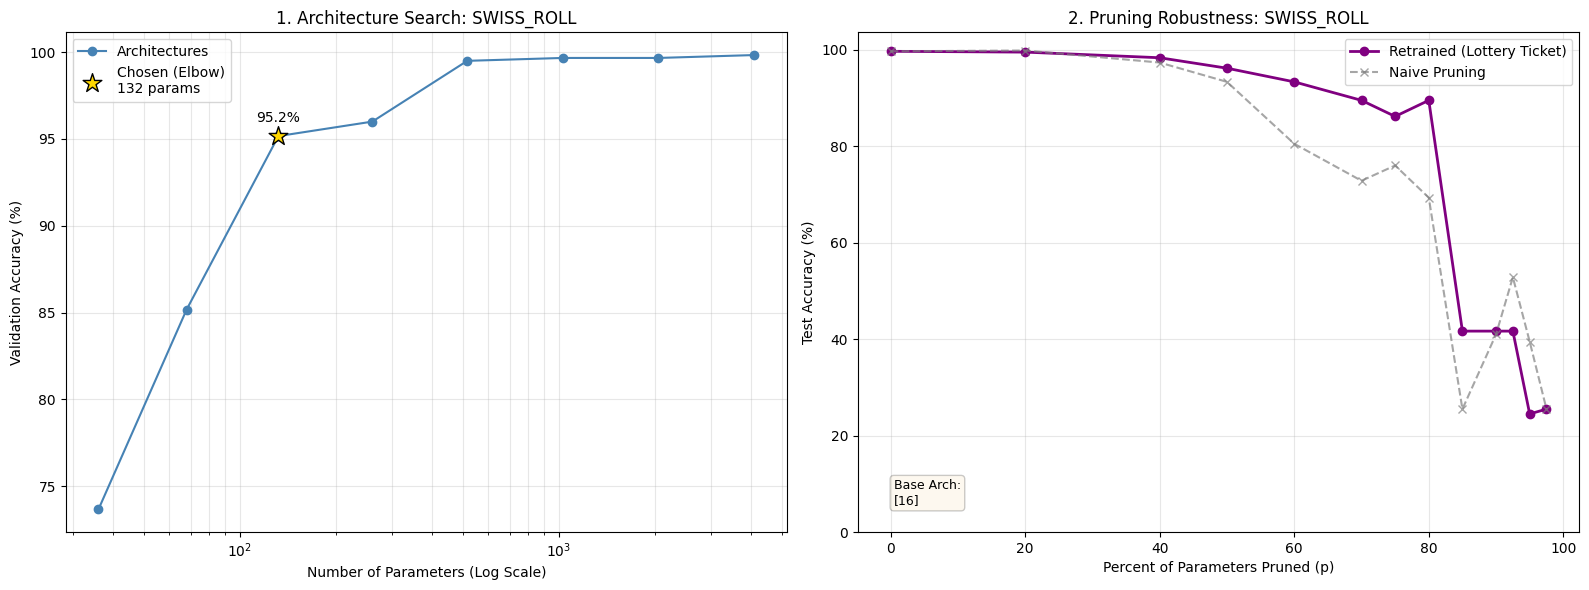

Generating summary for diabetes...


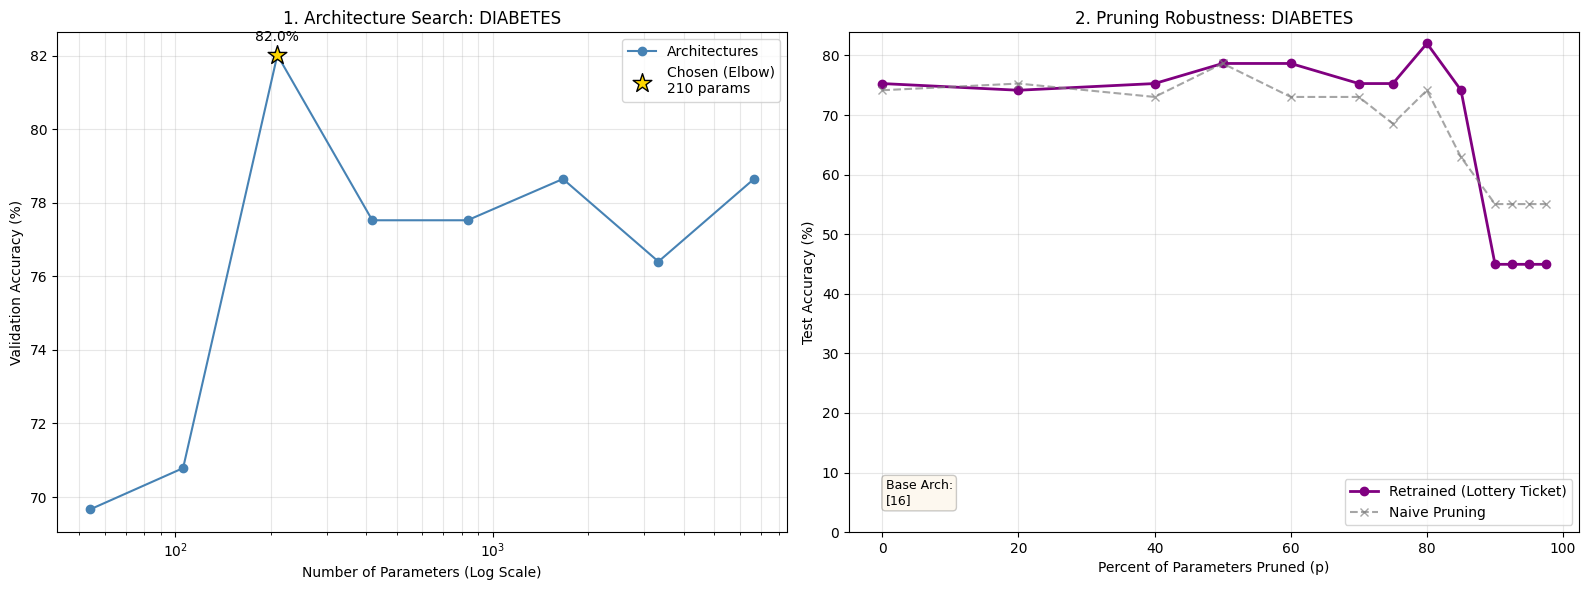

Generating summary for mnist...


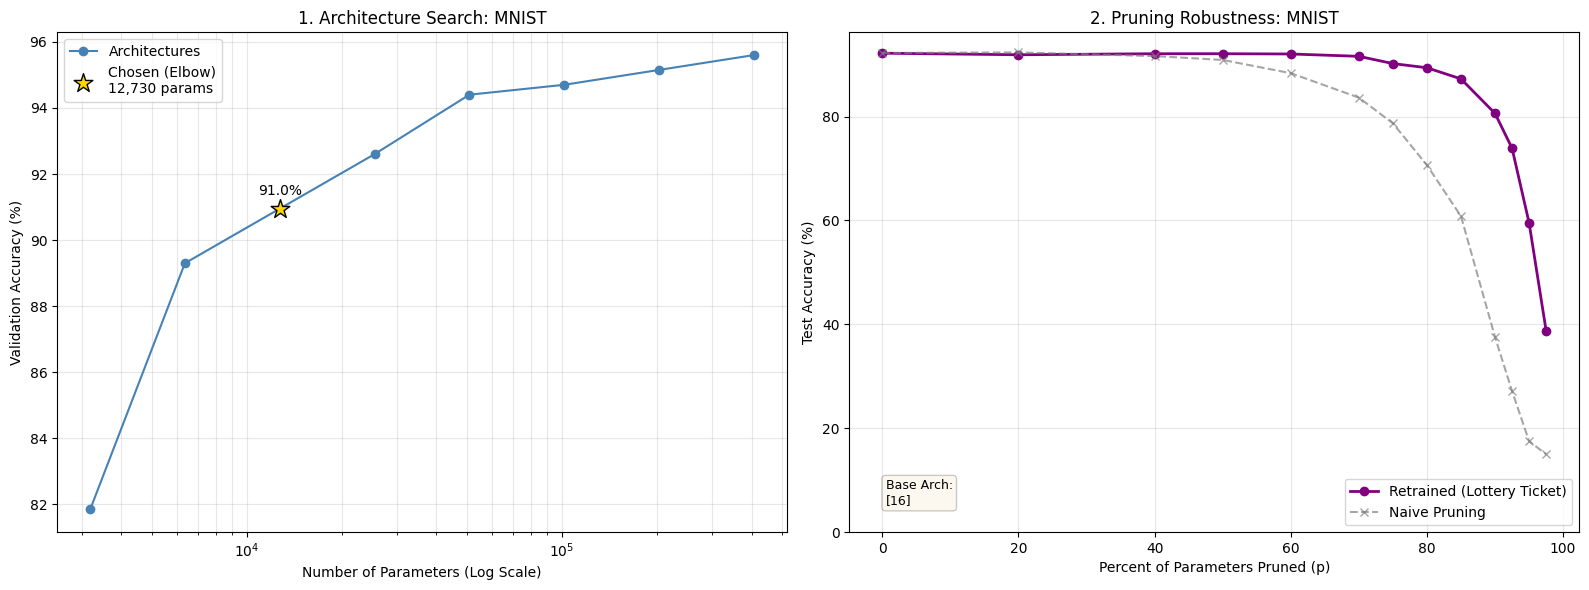

In [12]:
plot_all_results(datasets_to_run, arch_finders, experiments)

# Vizualization of Pruning
This part isn't necessary, but gives an intuition for how/why the pruning works. The description and graphs might be a little harder to understand in this section, so try to give some time to internalize what they show. 

I swear they're cool once you get it! 

## Focussing on Swiss Roll as an Example

We prune the weights that are closest to zero. Thus, compared to the original distribution of the weights, we get something flatter with more values away from 0.

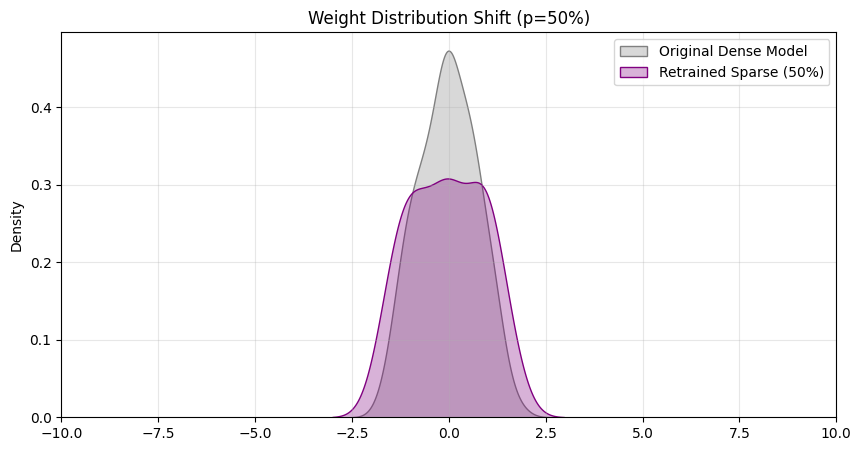

In [25]:
plot_weight_distribution(experiments[0], 50)

As expected from previous results, the average probability assigned to the correct class decreases with a similar trend to that seen before w.r.t $p$.

It is thus not a surprise that the standard deviation of the softmax distribution of model output has a similar trend. This shows that as we prune away more parameters, we get almost equal probabilities for each class regardless of input.

Analyzing trends across 4 classes...


/var/folders/px/v6h_m_713lg54rd8cj7pmkz00000gn/T/ipykernel_44449/1888102671.py:72: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = cm.get_cmap('tab10', num_classes)


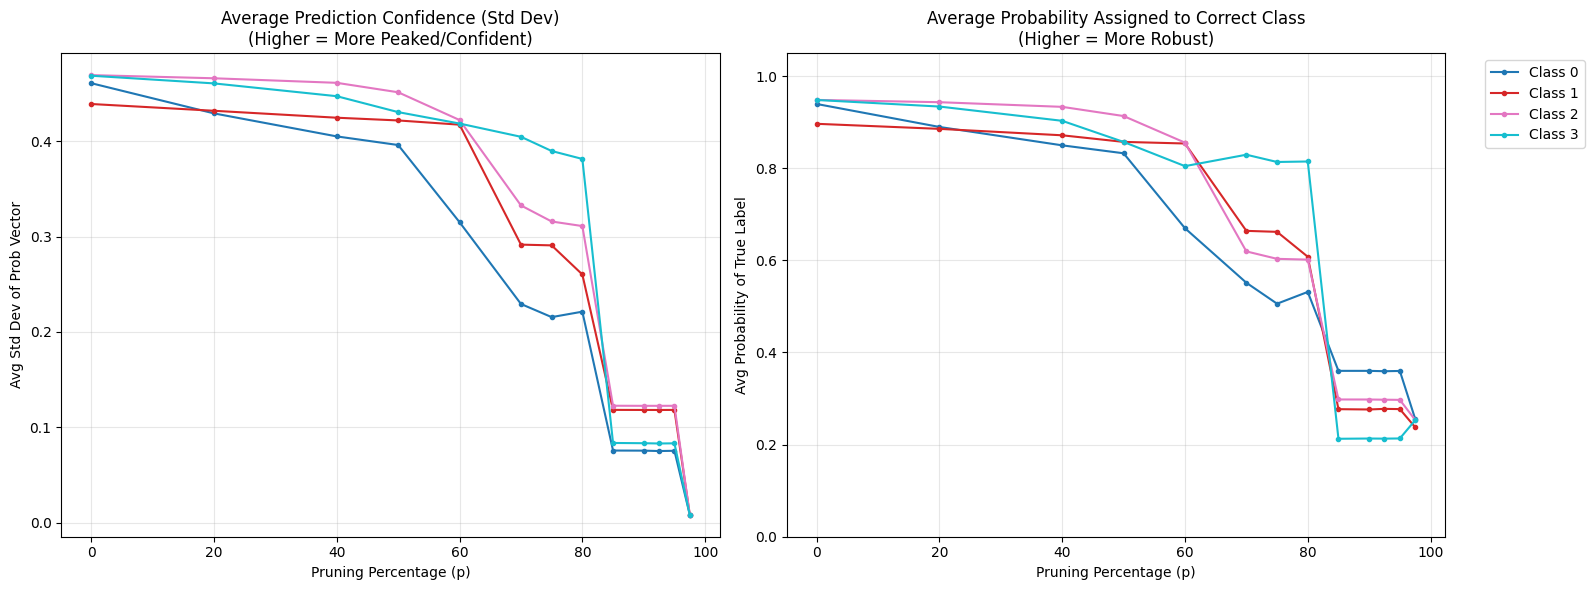

In [14]:
analyze_class_average_trends(experiments[0])

We chose the 16 neuron architecture for the swiss roll model, leading to 2 layers: in-16, and 16-out. We can see which weights are pruned as below.

Satisfyingly, the pruning removes all weights from the 1-th input, which as we can see from the swiss roll plot, is redundant. Thus this method somewhat acts as a redundancy removal mechanism!

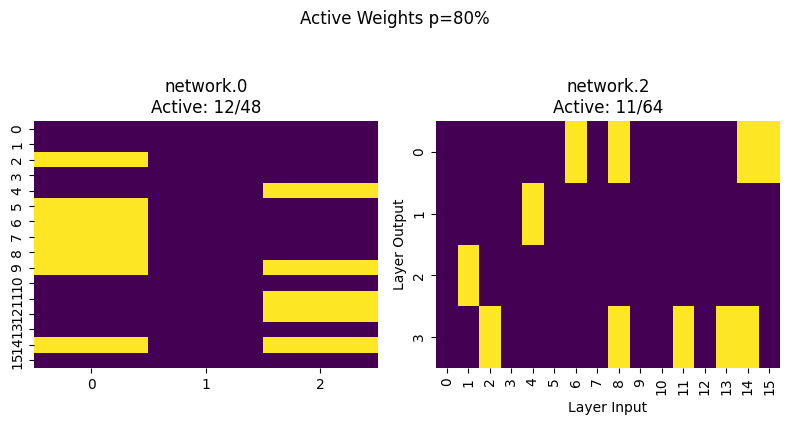

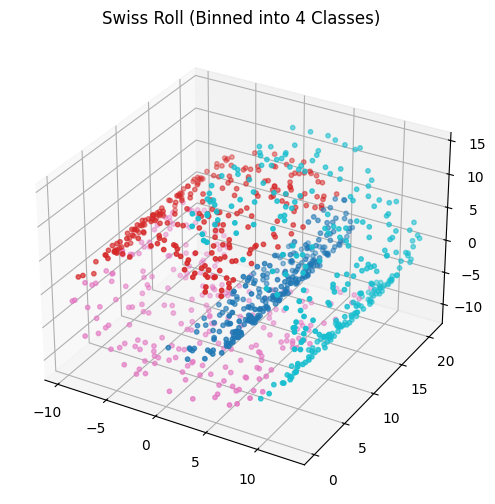

In [26]:
def visualize_swiss_roll():
    X, t = make_swiss_roll(n_samples=1000, noise=0.1)
    y = np.digitize(t, bins=np.linspace(np.min(t), np.max(t), 5)[1:-1])
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    sc = ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y, cmap='tab10', s=10)
    ax.set_title("Swiss Roll (Binned into 4 Classes)")
    plt.show()

experiments[0].visualize_masks(80)
visualize_swiss_roll()

## Focussing on MNIST

As we increase pruning, the parameters near the center of the image (in the input layer) get removed.
In fact, they get removed in a very similar pattern to an "Average" Image, indicating that these pixels do not differentiate one class from another. Because of this, the pruning removed this redundant information.

Visualizing Pixel Importance for Pruned Model (80% Pruned):
0% Pruned


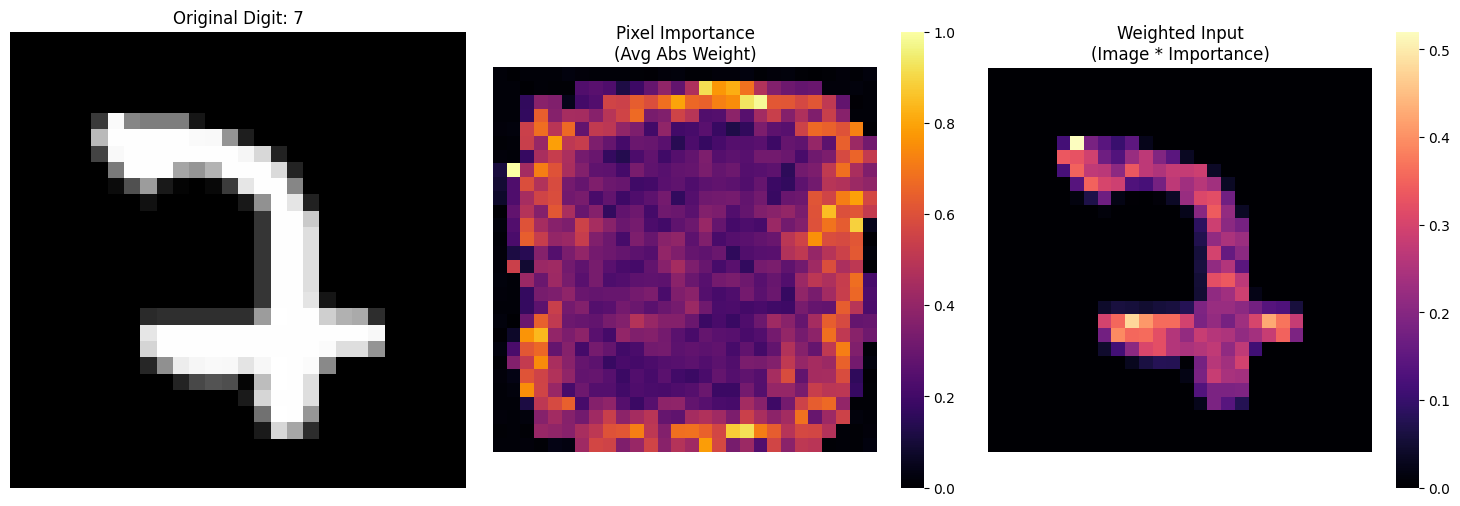

50% Pruned


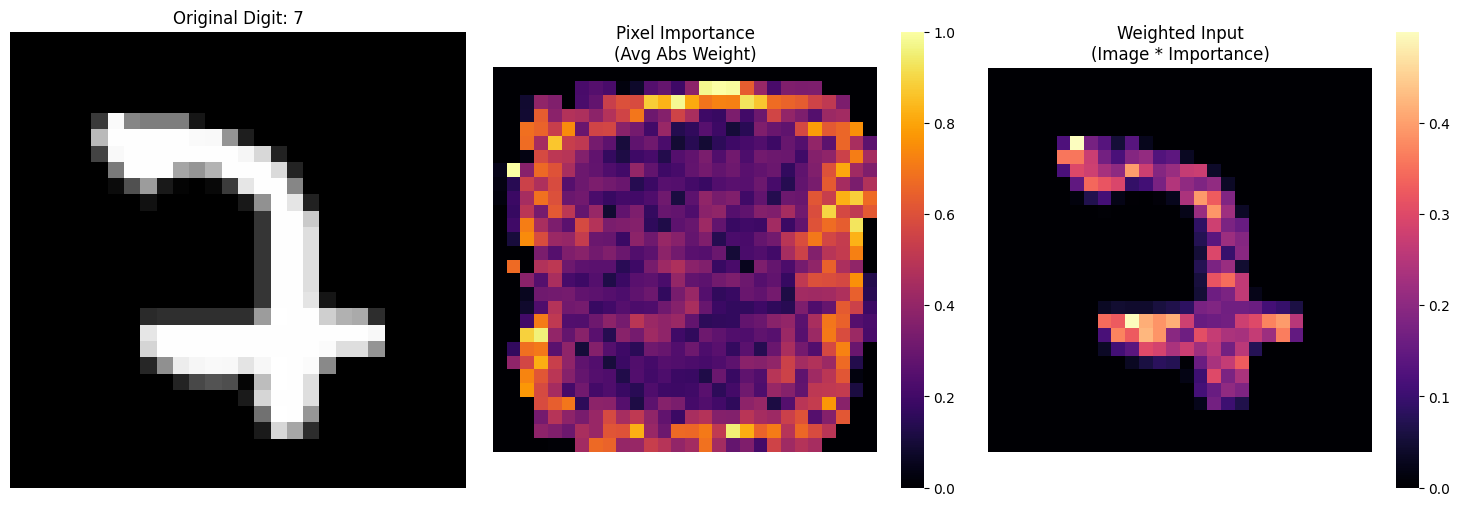

90% Pruned


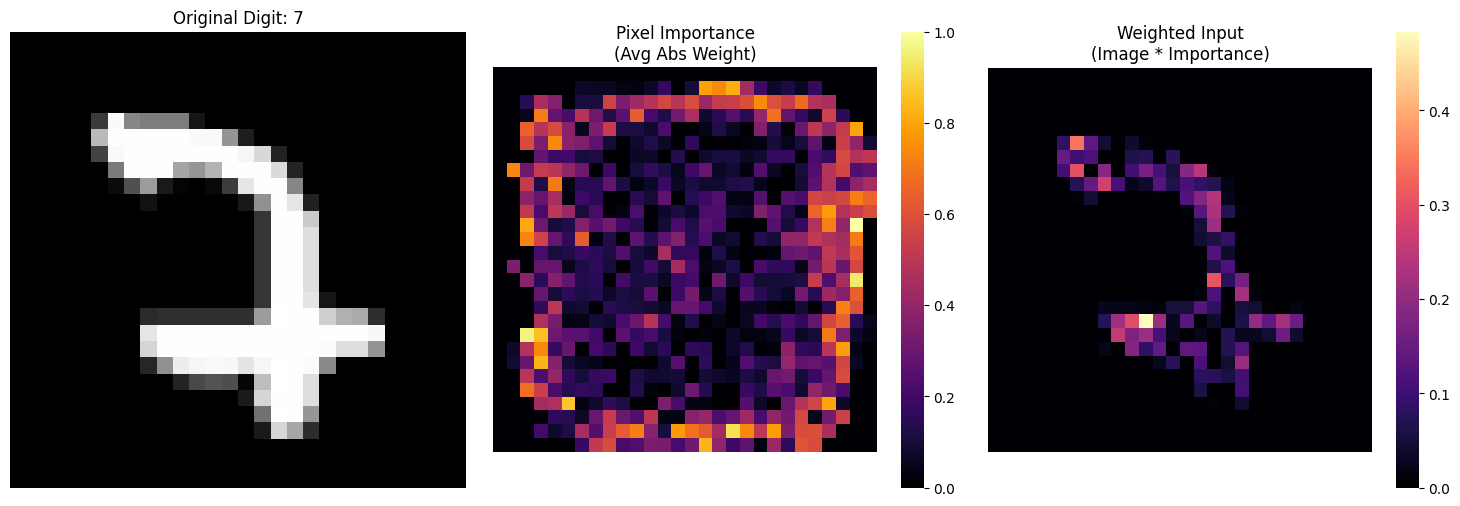

(np.float64(0.0), np.float64(28.0), np.float64(28.0), np.float64(0.0))

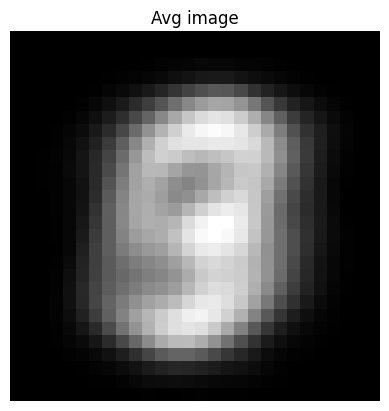

In [16]:
print("Visualizing Pixel Importance for Pruned Model (80% Pruned):")

print(f"0% Pruned")
pruned_model = FlexibleMLP(data.input_dim, data.output_dim, best_arch).to(device)
pruned_model.load_state_dict(experiments[2].history[0]['model_retrained_state'])
visualize_pixel_importance(pruned_model, data, sample_index=1)

print(f"50% Pruned")
pruned_model = FlexibleMLP(data.input_dim, data.output_dim, best_arch).to(device)
pruned_model.load_state_dict(experiments[2].history[50]['model_retrained_state'])
visualize_pixel_importance(pruned_model, data, sample_index=1)

print(f"90% Pruned")
pruned_model = FlexibleMLP(data.input_dim, data.output_dim, best_arch).to(device)
pruned_model.load_state_dict(experiments[2].history[80]['model_retrained_state'])
visualize_pixel_importance(pruned_model, data, sample_index=1)


# Over multiple images, add pixel valus and plot heatmap

sum_img = np.zeros((28, 28))

for imgs, y in data.test_loader:
  sum_img += np.sum(imgs.numpy(), axis=0).reshape(28, 28)

     # 4. Visualization
fig, axes = plt.subplots(1, 1)

# A. Original Image
sns.heatmap(sum_img, ax=axes, cmap="gray", cbar=False, square=True)
axes.set_title(f"Avg image")
axes.axis('off')


Similar to swiss roll, we see that the first row (col 1) from inputs are completely removed. This is because they are used as padding and are always zero in MNIST. So we have redundancy removal here as well!

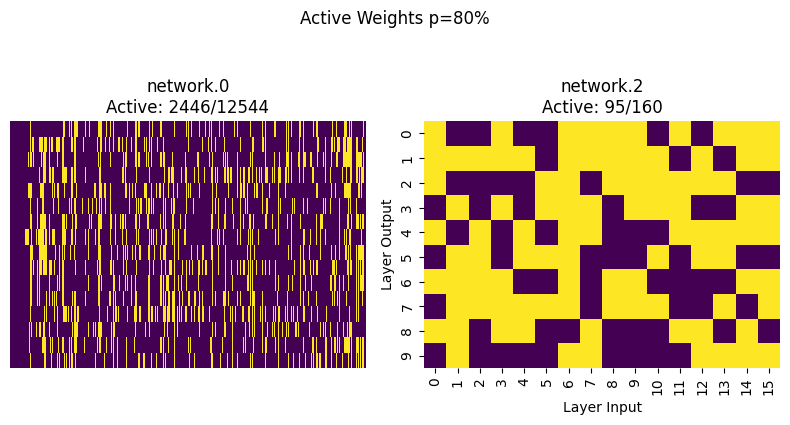

In [17]:
experiments[2].visualize_masks(80)

# Conclusion
This experiment has shown that in a diverse range of datasets, most parameters in fully connected NNs end up being 'wasted'. In fact, for our datasets, this is almost 80% of them! 

This means that if we identify the useful ones, we can potentially reduce the size of our model drastically, leading to more efficient models for inference. 

The main caveat, however, is that we don't know beforehand which parameters will be 'useful', and so we can't perform pruning before the training process. Moreover, the set of useful parameters changes based on the initialization of the model weights before training, making this process even harder! 

Upon further research, I found that this is an active area of work called the "Lottery Ticket Hypothesis", where a specific model initialization is called the 'lottery ticket' which determines which parameters 'win' or 'lose'. It was introduced in this 2018 paper: ["The Lottery Ticket Hypothesis: Finding Sparse, Trainable Neural Networks"](https://arxiv.org/abs/1803.03635). 
Since then there has been quite some work on finding a 'winning ticket' that will maximize the number of useful parameters in our model, thereby allowing us to reduce the overall architecture size. 

Fun! 